# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense

from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

# Importing Data

In [2]:
data = pd.read_csv('../input/thesis/dumy100000.csv')

# MCDM

# AHP

The Matrix is Consistent.
13.65 % -> A: 13648
24.95 % -> B: 24953
61.4 % -> C: 61399
Total:  100000


,mfg,sell,demand,fcost,rma,performance,RunCumCost,RunCostPerc,Rank,RunItemCum,RunItemPerc,Class
0,71,156.91,1595,49.7,3,0.276224,1494.307675,2.985227,6658.0,2.216781e+07,0.443352,C
1,474,1047.54,6877,331.8,3,0.873845,49945.574810,99.777899,99874.0,4.987458e+09,99.748160,A
2,70,154.70,5182,49.0,3,0.471743,15481.763973,30.928423,42637.0,9.089782e+08,18.179382,C
3,417,921.57,3914,291.9,3,0.668061,40135.751226,80.180495,86488.0,3.740130e+09,74.801858,A
4,239,528.19,4496,167.3,2,0.486306,17225.943313,34.412827,46278.0,1.070850e+09,21.416781,C


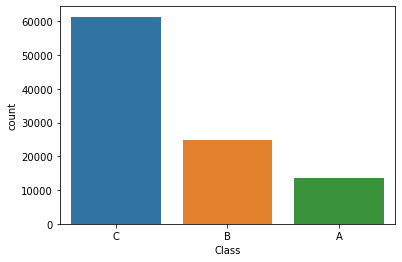

In [3]:
d_m = pd.read_csv('../input/pairwise/pairWiseMatrix.csv',index_col=0)

for i in range(5):
    d_m.iloc[:,i]=d_m.iloc[:,i]/d_m.iloc[:,i].sum()

d_m['criteria_weight'] = d_m.mean(axis=1)

dmat = pd.read_csv('../input/pairwise/pairWiseMatrix.csv',index_col=0)

for i in range(5):
    dmat.iloc[:,i] = dmat.iloc[:,i] * d_m.iloc[i,5]

dmat['weighted_sum_value'] = dmat.sum(axis=1)

dmat['weighted_sum_value/criteria_weight'] = dmat['weighted_sum_value']/d_m['criteria_weight']

lamda = dmat['weighted_sum_value/criteria_weight'].mean()
r = len(d_m.index)
CI = (lamda-r)/(r-1)
k= pd.read_csv('../input/pairwise/RCI.csv')
for i in range(15):
    if i==r-1:
        RI=k.iloc[i,1]

CR=CI/RI

if CR < 0.1:
    print("The Matrix is Consistent.")
else:
     print("The Matrix is In-Consistent.")

dn = 0
dn = data.copy()
del dn['Unnamed: 0']
d1 = dn.copy()

d2 = pd.DataFrame(columns = d1.columns)
d2 = d2.T
d2["max"] = 0
d2["min"] = 0
d2 = d2.T

for i in range(len(d2.columns)):
    d2.iloc[0,i] = d1.iloc[:,i].max()
    d2.iloc[1,i] = d1.iloc[:,i].min()

# max-min normalizer = 0
# linear normalizer = 1
normalizer = 0

if normalizer == 0 :
    for i in range(len(d1.columns)):
        if i==0 or i==3: #Non Beneficial
            d1.iloc[:,i] = (d2.iloc[0,i]-d1.iloc[:,i])/(d2.iloc[0,i] - d2.iloc[1,i])

        else: #Beneficial
            d1.iloc[:,i] = (d1.iloc[:,i]-d2.iloc[1,i])/(d2.iloc[0,i] - d2.iloc[1,i])

else:
    for i in range(len(d1.columns)):
        if i==0 or i==3: #Non Beneficial
            d1.iloc[:,i] = d2.iloc[1,i]/d1.iloc[:,i]

        else: #Beneficial
            d1.iloc[:,i] = d1.iloc[:,i]/ d2.iloc[0,i]

w = np.array(d_m["criteria_weight"]).reshape(1,5)
d1 = d1*w

d1['performance'] = d1.iloc[:].sum(axis=1)

dn['performance'] = d1['performance']
dn = dn.sort_values(by=['performance'], ascending=True)

dn['RunCumCost']   = dn['performance'].cumsum()
TotSum             = dn['performance'].sum()
dn['RunCostPerc']  = (dn['RunCumCost']/TotSum)*100

dn['Rank']         = dn['RunCostPerc'].rank()
dn['RunItemCum']   = dn['Rank'].cumsum()
TotItemSum         = dn['Rank'].sum()
dn['RunItemPerc']  = (dn['RunItemCum']/TotItemSum)*100

def ABC_segmentation(perc):
    '''
    top A - top 20%, C - last 50% and B - between A & C
    '''
    if perc > 80 :
        return 'A'
    elif perc >= 50 and perc <= 80:
        return 'B'
    elif perc < 50:
        return 'C'

dn['Class'] = dn['RunCostPerc'].apply(ABC_segmentation)

ax = sns.countplot(x = dn['Class'],data = dn,label= 'Count')
dn['Class'].value_counts()

dn['productid'] = dn.index
dn = dn.sort_values(by=['productid'], ascending=True)
del dn['productid']
AHP_Class = dn['Class']

C,B,A = dn['Class'].value_counts()
print(round(100*A/dn['Class'].value_counts().sum(),2),"% ->","A:",A)
print(round(100*B/dn['Class'].value_counts().sum(),2),"% ->","B:",B)
print(round(100*C/dn['Class'].value_counts().sum(),2),"% ->","C:",C)
print("Total: ",dn['Class'].value_counts().sum())
dn.head()

# Machine Learning

In [4]:
iteration = 5
row_col = np.zeros([iteration,])

acc = pd.DataFrame()
acc['train_Acc'] = row_col
acc['test_Acc']  = row_col
acc['time']      = row_col
acc['test_size'] = row_col
start_time  = 0
end_time    = 0
train_score = 0
test_score  = 0

#split_size 
n = .1

# ANN

In [5]:
for i in range(iteration):
      
    X = dn.iloc[:,0:5].astype('float32')
    y = dn['Class'] #.iloc[0:100,-1] 

    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    y = to_categorical(y)

    X_train,X_test,y_train,y_test = train_test_split(X, y ,test_size = n, random_state=0)
    X_train,X_val,y_train,y_val = train_test_split(X_train, y_train ,test_size = n, random_state=0)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test  = sc.fit_transform(X_test)
    X_val  = sc.fit_transform(X_val)
           
    #time start
    start_time = time.time()
    
    model = Sequential()
    model.add(Dense(5, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train,y_train,batch_size = 128, epochs = 20, validation_data = (X_val,y_val))

    #time end
    end_time = time.time()
        
    train_score = model.evaluate(X_train,y_train,verbose=0)
    test_score = model.evaluate(X_test,y_test,verbose=0)
       
    #time calculation 
    acc.iloc[i,2] = end_time - start_time
    
    #Accuracy
    acc.iloc[i,0] = train_score[1]*100
    acc.iloc[i,1] = train_score[1]*100
    
    #test size
    acc.iloc[i,3] = n*100
    
    if n == .1:
        n = .2
    else :
        n = .1

Epoch 1/20
633/633 [==============================] - 2s 2ms/step - loss: 0.9913 - accuracy: 0.6493 - val_loss: 0.4076 - val_accuracy: 0.8039
Epoch 2/20
633/633 [==============================] - 1s 1ms/step - loss: 0.3372 - accuracy: 0.8769 - val_loss: 0.2347 - val_accuracy: 0.9396
Epoch 3/20
633/633 [==============================] - 1s 1ms/step - loss: 0.2175 - accuracy: 0.9532 - val_loss: 0.1721 - val_accuracy: 0.9718
Epoch 4/20
633/633 [==============================] - 1s 1ms/step - loss: 0.1609 - accuracy: 0.9759 - val_loss: 0.1352 - val_accuracy: 0.9793
Epoch 5/20
633/633 [==============================] - 1s 1ms/step - loss: 0.1273 - accuracy: 0.9832 - val_loss: 0.1114 - val_accuracy: 0.9853
Epoch 6/20
633/633 [==============================] - 1s 1ms/step - loss: 0.1048 - accuracy: 0.9869 - val_loss: 0.0949 - val_accuracy: 0.9868
Epoch 7/20
633/633 [==============================] - 1s 1ms/step - loss: 0.0897 - accuracy: 0.9893 - val_loss: 0.0832 - val_accuracy: 0.9893
Epoch 

In [6]:
acc = acc.round(2)
acc

,train_Acc,test_Acc,time,test_size
0,99.75,99.75,17.00,10.0
1,99.73,99.73,13.61,20.0
2,99.81,99.81,16.04,10.0
3,99.91,99.91,13.77,20.0
4,99.87,99.87,16.25,10.0


In [7]:
ANNAcc = acc.mean()
ANNAcc

train_Acc    99.814
test_Acc     99.814
time         15.334
test_size    14.000
dtype: float64

# SVM

In [8]:
n = .1
for i in range(iteration):
    
    X = dn.iloc[:,0:5].astype('float32')
    y = dn['Class']

    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = n, random_state=0)
    
    #time start
    start_time = time.time()
    
    
    model = SVC(kernel='poly')
    model.fit(X_train,y_train)
    
    #time end
    end_time = time.time()

    train_score = model.score(X_train,y_train)
    test_score  = model.score(X_test,y_test)
    
    #time calculation 
    acc.iloc[i,2] = end_time - start_time
    
    #Accuracy
    acc.iloc[i,0] = train_score*100
    acc.iloc[i,1] = test_score*100
    
    #test size
    acc.iloc[i,3] = n*100

    if n == .1:
        n = .2
    else :
        n = .1
    print(i+1," run")

1  run
2  run
3  run
4  run
5  run


In [9]:
acc = acc.round(2)
acc

,train_Acc,test_Acc,time,test_size
0,77.87,77.82,122.13,10.0
1,77.83,77.84,97.32,20.0
2,77.87,77.82,123.19,10.0
3,77.83,77.84,97.60,20.0
4,77.87,77.82,122.43,10.0


In [10]:
SVMAcc = acc.mean()
SVMAcc

train_Acc     77.854
test_Acc      77.828
time         112.534
test_size     14.000
dtype: float64

# KNN

In [11]:
n = .1
for i in range(iteration):
    
    X = dn.iloc[:,0:5].astype('float32')
    y = dn['Class']

    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = n, random_state=0)

    
    #time start
    start_time = time.time()
        
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train,y_train)
    
    #time end
    end_time = time.time()

    train_score = model.score(X_train,y_train)
    test_score  = model.score(X_test,y_test)
    
    #time calculation 
    acc.iloc[i,2] = end_time - start_time
    
    #Accuracy
    acc.iloc[i,0] = train_score*100
    acc.iloc[i,1] = test_score*100
    
    #test size
    acc.iloc[i,3] = n*100
    
    if n == .1:
        n = .2
    else :
        n = .1
    print(i+1," run")

1  run
2  run
3  run
4  run
5  run


In [12]:
acc = acc.round(2)
acc

,train_Acc,test_Acc,time,test_size
0,87.11,75.05,0.11,10.0
1,87.00,74.99,0.09,20.0
2,87.11,75.05,0.11,10.0
3,87.00,74.99,0.09,20.0
4,87.11,75.05,0.11,10.0


In [13]:
KNNAcc = acc.mean()
KNNAcc

train_Acc    87.066
test_Acc     75.026
time          0.102
test_size    14.000
dtype: float64

# GPC

In [14]:
n = .1
for i in range(iteration):
    
    X = dn.iloc[:,0:5].astype('float32')
    y = dn['Class']

    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = n, random_state=0)

    
    #time start
    start_time = time.time()
        
    model = GaussianProcessClassifier(multi_class='one_vs_one')
    model.fit(X_train,y_train)
    
    #time end
    end_time = time.time()

    train_score = model.score(X_train,y_train)
    test_score  = model.score(X_test,y_test)
    
    #time calculation 
    acc.iloc[i,2] = end_time - start_time
    
    #Accuracy
    acc.iloc[i,0] = train_score*100
    acc.iloc[i,1] = test_score*100
    
    #test size
    acc.iloc[i,3] = n*100

    if n == .1:
        n = .2
    else :
        n = .1
    print(i+1," run")

1  run
2  run
3  run
4  run
5  run


In [15]:
acc = acc.round(2)
acc

,train_Acc,test_Acc,time,test_size
0,100.0,73.60,105.62,10.0
1,100.0,73.35,79.16,20.0
2,100.0,73.60,106.46,10.0
3,100.0,73.35,79.50,20.0
4,100.0,73.60,105.55,10.0


In [16]:
GPCAcc = acc.mean()
GPCAcc

train_Acc    100.000
test_Acc      73.500
time          95.258
test_size     14.000
dtype: float64

In [17]:
performance = {
    "Performance" : ['Avg Train Accuracy','Avg Test Accuracy','Avg Run Time','Avg Test size'],
    "ANN"         : ANNAcc,
    "SVM"         : SVMAcc,
    "KNN"         : KNNAcc,
    "GPC"         : GPCAcc
}
Performance = pd.DataFrame(performance)
Performance

,Performance,ANN,SVM,KNN,GPC
train_Acc,Avg Train Accuracy,99.814,77.854,87.066,100.000
test_Acc,Avg Test Accuracy,99.814,77.828,75.026,73.500
time,Avg Run Time,15.334,112.534,0.102,95.258
test_size,Avg Test size,14.000,14.000,14.000,14.000


In [18]:
pm = np.array([1,3,5,1/3,1,3,1/5,1/3,1]).reshape(3,3) #consistancy matrix
pm = pd.DataFrame(pm)


for i in range(3):
    pm.iloc[:,i]=pm.iloc[:,i]/pm.iloc[:,i].sum()

pm['criteria_weight'] = pm.mean(axis=1)

pmat = np.array([1,3,5,1/3,1,3,1/5,1/3,1]).reshape(3,3)#pd.read_csv('../input/pairwise/pairWiseMatrix.csv',index_col=0)
pmat = pd.DataFrame(pmat)

for i in range(3):
    pmat.iloc[:,i] = pmat.iloc[:,i] * pm.iloc[i,3]

pmat['weighted_sum_value'] = pmat.sum(axis=1)

pmat['weighted_sum_value/criteria_weight'] = pmat['weighted_sum_value']/pm['criteria_weight']

lamda = pmat['weighted_sum_value/criteria_weight'].mean()
r = len(pm.index)
CI = (lamda-r)/(r-1)
k= pd.read_csv('../input/pairwise/RCI.csv')
for i in range(15):
    if i==r-1:
        RI=k.iloc[i,1]

CR=CI/RI

if CR < 0.1:
    print("The Matrix is Consistent.")
else:
     print("The Matrix is In-Consistent.")

The Matrix is Consistent.


In [19]:
p1 = Performance.iloc[0:3,1:5].T
p2 = pd.DataFrame(columns = p1.columns)
p2 = p2.T
p2["max"] = 0
p2["min"] = 0
p2 = p2.T
for i in range(len(p2.columns)):
    p2.iloc[0,i] = p1.iloc[:,i].max()
    p2.iloc[1,i] = p1.iloc[:,i].min()

# max-min normalizer = 0
# linear normalizer = 1
normalizer = 0

if normalizer == 0 :
    for i in range(len(p1.columns)):
        if i==2: #Non Beneficial
            p1.iloc[:,i] = (p2.iloc[0,i]-p1.iloc[:,i])/(p2.iloc[0,i] - p2.iloc[1,i])

        else: #Beneficial
            p1.iloc[:,i] = (p1.iloc[:,i]-p2.iloc[1,i])/(p2.iloc[0,i] - p2.iloc[1,i])

else:
    for i in range(len(p1.columns)):
        if i==2: #Non Beneficial
            p1.iloc[:,i] = p2.iloc[1,i]/p1.iloc[:,i]

        else: #Beneficial
            p1.iloc[:,i] = p1.iloc[:,i]/ p2.iloc[0,i]

#weight = np.array(pm["criteria_weight"]).reshape(1,3)
weight = np.array([0.5,0.3,0.2]).reshape(3,1)
p1["p-w"] = np.dot(p1,weight)
p1

,train_Acc,test_Acc,time,p-w
ANN,0.991601,1.000000,0.864523,0.968705
SVM,0.000000,0.164475,0.000000,0.049343
KNN,0.415967,0.057992,1.000000,0.425381
GPC,1.000000,0.000000,0.153657,0.530731


In [20]:
p1.round(2)

,train_Acc,test_Acc,time,p-w
ANN,0.99,1.00,0.86,0.97
SVM,0.00,0.16,0.00,0.05
KNN,0.42,0.06,1.00,0.43
GPC,1.00,0.00,0.15,0.53
